# Bayesian neural network

In [22]:
import numpy as np
import tensorflow as tf
import edward as ed
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import gzip
import pickle

from keras.utils import to_categorical

ImportError: No module named 'keras'

In [15]:
from edward.models import Normal

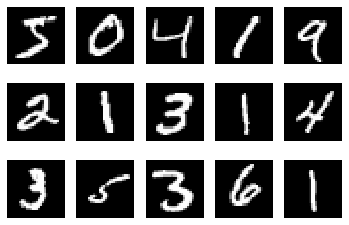

In [21]:
# DATA
def load_mnist():
    """
    Loads the MNIST handwritten digits dataset into three tuples training_data/

    :return: Three tuples containing training data, validation data and test data
    """
    f = gzip.open(r'C:\Code\neural-nets\data\mnist.pkl.gz')
    training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
    f.close()
    return training_data, validation_data, test_data

training_data, validation_data, test_data = load_mnist()

def show_grid_of_digits(data,nc,nr):
    for i in range(nc*nr):
        plt.subplot(nc,nr,i+1)
        im = data[0][i].reshape(28,28)
        plt.imshow(im,cmap='gray')
        plt.gca().axes.get_xaxis().set_visible(False)
        plt.gca().axes.get_yaxis().set_visible(False)
        
show_grid_of_digits(training_data,3,5)

In [45]:
def multilayer_perceptron(x, weights, biases):
    """
    This function takes in the input placeholder, weights and biases and returns the output tensor of a network with
    two hidden ReLU layers, and an output layer with linear activation.

    :param tf.placeholder x: Placeholder for input
    :param dict weights: Dictionary containing Variables describing weights of each layer
    :param dict biases: Dictionary containing Variables describing biases of each layer
    :return: The activations of the output layer
    """
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    # Hidden layer with RELU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    # Output layer with linear activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

n_input = 28**2
n_hidden_1 = 10
n_hidden_2 = 10
n_classes = 10

batch_size = 20

# Priors on layers weight & bias
weights = {
    'h1': Normal(loc=tf.zeros([n_input, n_hidden_1]), scale=tf.ones([n_input, n_hidden_1])), 
    'h2': Normal(loc=tf.zeros([n_hidden_1, n_hidden_2]), scale=tf.ones([n_hidden_1, n_hidden_2])),
    'out': Normal(loc=tf.zeros([n_hidden_2, n_classes]), scale=tf.ones([n_hidden_2, n_classes]))
}
biases = {
    'b1': Normal(loc=tf.zeros(n_hidden_1), scale=tf.ones(n_hidden_1)),# tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': Normal(loc=tf.zeros(n_hidden_2), scale=tf.ones(n_hidden_2)),#tf.Variable(tf.random_normal([n_hidden_2])),
    'out': Normal(loc=tf.zeros(n_classes), scale=tf.ones(n_classes))#tf.Variable(tf.random_normal([n_classes]))
}

x = tf.placeholder(tf.float32, [batch_size, n_input])
y = Normal(loc=multilayer_perceptron(x, weights, biases),scale=tf.ones(n_classes) * 0.1)  # constant noise

In [46]:
# BACKWARD MODEL 

q_weights = {
    'h1':  Normal(loc=tf.Variable(tf.random_normal([n_input, n_hidden_1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([n_input, n_hidden_1])))), 
    'h2': Normal(loc=tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])))),
    'out': Normal(loc=tf.Variable(tf.random_normal([n_hidden_2, n_classes])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([n_hidden_2, n_classes]))))
}
q_biases = {
    'b1': Normal(loc=tf.Variable(tf.random_normal([n_hidden_1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([n_hidden_1])))),
    'b2': Normal(loc=tf.Variable(tf.random_normal([n_hidden_2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([n_hidden_2])))),
    'out': Normal(loc=tf.Variable(tf.random_normal([n_classes])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([n_classes]))))
}



In [53]:
batch_x = training_data[0][:20]
batch_y = to_categorical(training_data[1][:20])

In [54]:
# INFERENCE 
# this will take a couple of minutes

latent_vars = {weights['h1']: q_weights['h1'], biases['b1']: q_biases['b1'],
              weights['h2']: q_weights['h2'], biases['b2']: q_biases['b2'],
              weights['out']: q_weights['out'], biases['out']: q_biases['out']}

inference = ed.KLqp(latent_vars=latent_vars, 
                    data={x: batch_x, y:batch_y})

inference.run(n_samples=10, n_iter=25000)

25000/25000 [100%] ██████████████████████████████ Elapsed: 442s | Loss: 5028.379


In [56]:
batch_y

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

In [50]:
batch_y

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9], dtype=int64)

In [55]:
from edward.models import Categorical